# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [93]:
# Do all imports and installs here
import pandas as pd
import os
import glob
import re
from datetime import datetime, timedelta
from pyspark.sql.types import StringType, IntegerType, StructField, StructType, LongType
import configparser
import boto3
from pandas import DataFrame
import csv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, upper, first
from pyspark.sql.functions import udf, date_format
import datetime as dt
from matplotlib import pyplot as plt
# Create Spark session
spark = SparkSession.builder.\
        config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

This project has the goal to analyze immigration in the US through the databases which will be changed for the data to have a character understandable.
The data come from several sources, and the cluster of data on immigration comes from the US National Tourism and Trade Office.
The data of World Temperature come from Kaggle and as well as OpenSoft offers the US city demographic data where the user will be able to study statistic data about the population which the user can differ by race, age, region, etc.
With the databases, the information which it was obtained, will be used to create a fact table (called immigration_fact) and three tables of dimensions (called immigrant_dimension, demographic_dimension, and temperature_dimension), and Spark will be used for ETL jobs and store the outcomes in parquet.

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

1.	There is to analyze the immigration data and change the columns for giving an outcome understandable and readable such as changing the columns of time to a format year/month/day and drop the columns that they do not give any information.
2.	World Temperature Data will be assessed and it will be just included the data where the column of “country” is equal to “United States” and the column of “date” will be just included the data after the century XX.
3.	The U.S. City Demographic Data will be assessed for the outcomes are understandable and besides, it will be shown some graphic where the users will be able to see a distribution of the U.S. population divided by race and divided by age with percentages.
4.	Finally, the tables (fact table and dimensions tables) will be created and saved the process in a parquet for downstream query, so the users will manage to consult in the future.

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

# Objective

We are going to analyze the data of immigration which are come from the US National Tourism and Trade Office, as well as the data of world temperature that are come from the website of Kaggle and besides the demographics data from the US cities which are come of OpenSoft. 

These data will be checked, assessed, and dropped (data no relevant for the project).

## IMMIGRATION

Bellow, the immmigration data will be read and they will be analyzed and assessed.

In [94]:
# Read immigration data
# Assumption for the project: in this project only the i94_apr16_sub.sas7bdat will be used, 
# in order to all process all of the available files, simple use i94_files
i94_immigration_data_files = glob.glob("../../data/18-83510-I94-Data-2016/*.sas7bdat")
i94_immigration_data_files_fname = "../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat"
i94_immigration_data = spark.read.format("com.github.saurfang.sas.spark").load(i94_immigration_data_files_fname)

In [95]:
i94_immigration_data.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [96]:
# The number of rows of the immigration table will be counted
i94_immigration_data.count()

3096313

In [97]:
i94_immigration_data.limit(2).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,None,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,None,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1


In [98]:
i94_immigration_data.show(2)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|       admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null|1.897628485E9| null|      B2|
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SEO| n

In [99]:
# At this function will analyze the different cases relating to the immigration table called "i94_df" where the column will be renamed
# and the type of columns can also be changed with the instruction "cast"
def immigration(table, option):
    if option == 1:
        table = table.select(col('cicid').alias('id_immigration').cast("float"), col('i94yr').alias('year').cast("float"),
                             col('i94mon').alias('month').cast("int"), col('i94cit').alias('code_origin').cast("float"), 
                             col('i94res').alias('code_destination').cast("float"), col('i94port').alias('code_city_destination'), 
                             col('arrdate').alias('arrival_date'), col('i94mode').alias('code_travel').cast("int"), 
                             col('i94addr').alias('addr'), 'depdate', col('i94bir').alias('birth').cast("int"), 
                             col('i94visa').alias('visa').cast("string"), 'dtadfile', 'visapost' , 'occup', 'entdepa', 
                             'entdepd', 'entdepu', 'matflag', col('biryear').cast("float"), 'dtaddto', 
                             'gender', 'insnum', 'airline', col('admnum').alias('admission_number'), 'fltno', 'visatype')
        # Drop the `state` column
        table = table.drop("visapost", "occup", "entdepa", "entdepd", "entdepu","matflag", "insnum", 
                           "count", "year","month", "dtadfile","dtaddto", "fltno")
        return table
    elif option == 2:
        table = table.select('id_immigration', col('res_city').alias('origin'), 'code_destination', 'code_city_destination', 
                             'arrival_date', 'code_travel', 'addr', 'depdate', 'birth', 'visa', 'biryear', 'gender', 
                             'airline', 'admission_number', 'visatype', 'port_city', 'port_state')
        return table
    elif option == 3:
        table = table.select('id_immigration', 'origin', col('res_city').alias('destination'), 'code_city_destination', 'arrival_date', 
                             'code_travel', 'addr', 'depdate', 'birth', 'visa', 'biryear', 'gender', 'airline', 'admission_number', 
                             'visatype', 'port_city', 'port_state')
        table = table.drop("port_state")
        return table
    elif option == 4:
        table = table.select('id_immigration', 'origin', 'destination', 'code_city_destination', 'arrival_date', 
                             col('type').alias('travel'), 'addr', 'depdate', 'birth', 'visa', 'biryear', 'gender', 'airline', 
                             'admission_number', 'visatype', 'port_city')
        # Drop the `state` column
        table = table.drop("code_travel", "numbers_code_travel")
        return table
    elif option == 5:
        table = table.select('id_immigration', 'origin', 'destination', 'code_city_destination', 'arrival_date', 'travel',
                             'addr', 'depdate', 'birth', 'biryear', 'gender', 'airline', 'admission_number',
                              'type', 'visatype', 'port_city')
        # Drop the `state` column
        table = table.drop("visa", "numbers_visa")
        return table
    else:
        return None

In [100]:
# immigration data will be assessed with the function "immigration" and option 1
i94_df = immigration(i94_immigration_data, 1)
i94_df.limit(2).toPandas()

,id_immigration,code_origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype
0,6.0,692.0,692.0,XXX,20573.0,NaN,None,None,37,2.0,1979.0,None,None,1.897628e+09,B2
1,7.0,254.0,276.0,ATL,20551.0,1.0,AL,None,25,3.0,1991.0,M,None,3.736796e+09,F1


In [101]:
i94_df.printSchema()

root
 |-- id_immigration: float (nullable = true)
 |-- code_origin: float (nullable = true)
 |-- code_destination: float (nullable = true)
 |-- code_city_destination: string (nullable = true)
 |-- arrival_date: double (nullable = true)
 |-- code_travel: integer (nullable = true)
 |-- addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- birth: integer (nullable = true)
 |-- visa: string (nullable = true)
 |-- biryear: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- visatype: string (nullable = true)



In [102]:
# This function is created to change the format of the time. It is changed to a format that can be understood (year/month/day). 
# The first day is 1960/01/01 
@udf(StringType())
def convert_datetime(x):
    if x:
        return (datetime(1960, 1, 1).date() + timedelta(x)).isoformat()
    return None

In [103]:
# The function "convert_datatime" is used to change the format of the columns of "arrival_date" and "depdate"
i94_df = i94_df.withColumn('arrival_date', convert_datetime(i94_df.arrival_date))
i94_df = i94_df.withColumn('depdate', convert_datetime(i94_df.depdate))
i94_df.limit(5).toPandas()

,id_immigration,code_origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype
0,6.0,692.0,692.0,XXX,2016-04-29,NaN,None,None,37,2.0,1979.0,None,None,1.897628e+09,B2
1,7.0,254.0,276.0,ATL,2016-04-07,1.0,AL,None,25,3.0,1991.0,M,None,3.736796e+09,F1
2,15.0,101.0,101.0,WAS,2016-04-01,1.0,MI,2016-08-25,55,2.0,1961.0,M,OS,6.666432e+08,B2
3,16.0,101.0,101.0,NYC,2016-04-01,1.0,MA,2016-04-23,28,2.0,1988.0,None,AA,9.246846e+10,B2
4,17.0,101.0,101.0,NYC,2016-04-01,1.0,MA,2016-04-23,4,2.0,2012.0,None,AA,9.246846e+10,B2


In [104]:
i94_df.count()

3096313

In [105]:
# With the instruction "dropDuplicates" is removed the columns that are repeated
i94_df = i94_df.dropDuplicates()

In [106]:
i94_df.count()

3096313

In [107]:
# The colounm "numbers_code_travel" has a format that is tough to understand and we are going to associate the number with their meaning 
# Bellow, we can see what they mean each number

'''
/* I94MODE - There are missing values as well as not reported (9) */
    1 = 'Air'
    2 = 'Sea'
    3 = 'Land'
    9 = 'Not reported' ;
'''
# Create i94mode list
i94code_travel =[[1,'Air'],[2,'Sea'],[3,'Land'],[9,'Not reported']]

# Convert to spark dataframe
i94mode=spark.createDataFrame(i94code_travel)

i94code_travel = pd.DataFrame({'numbers_code_travel': [1, 2, 3, 9], 'type': ['Air', 'Sea', 'Land', 'Rot reported']})
i94code_travel=spark.createDataFrame(i94code_travel)
i94code_travel.show()

+-------------------+------------+
|numbers_code_travel|        type|
+-------------------+------------+
|                  1|         Air|
|                  2|         Sea|
|                  3|        Land|
|                  9|Rot reported|
+-------------------+------------+



In [108]:
# The dictionary will be read with the ports so that in the future the data will be filtered and made more understandable
i94port = pd.read_csv('I94_SAS_Labels_Descriptions.SAS',sep='=',names=['id','port'])

# Remove whitespaces and single quotes
i94port['id']=i94port['id'].str.strip().str.replace("'",'')

# Create two columns from i94port string: port_city and port_addr
# also remove whitespaces and single quotes
i94port['port_city'], i94port['port_state']=i94port['port'].str.strip().str.replace("'",'').str.strip().str.split(',',1).str

# Remove more whitespace from port_addr
i94port['port_state']=i94port['port_state'].str.strip()

# Drop port column and keep the two new columns: port_city and port_addr
i94port.drop(columns =['port'], inplace = True)

# Convert pandas dataframe to list (objects which had single quotes removed automatically become string again with single quotes)
i94port_data=i94port.values.tolist()

i94port_data = i94port_data[297:957]
print(i94port_data[0:1])
print(i94port_data[658:660])

[['ALC', 'ALCAN', 'AK']]
[['A2A', 'No PORT Code (A2A)', nan], ['OSN', 'No PORT Code (OSN)', nan]]


In [109]:
# Now convert list to spark dataframe
# Create a schema for the dataframe
i94port = StructType([
    StructField('id', StringType(), True),
    StructField('port_city', StringType(), True),
    StructField('port_state', StringType(), True)
])
i94port=spark.createDataFrame(i94port_data, i94port)
i94port.limit(5).toPandas()

,id,port_city,port_state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


In [110]:
# Read i94res text file
i94res_df = pd.read_csv('I94_SAS_Labels_Descriptions.SAS',sep='=',names=['id','country'])
# Remove whitespaces and single quotes
i94res_df['country']=i94res_df['country'].str.replace("'",'').str.strip()
# Convert pandas dataframe to list (objects which had single quotes removed automatically become string again with single quotes)
i94res_data=i94res_df.values.tolist()

i94res_data = i94res_data[6:295]
print(i94res_data[0:1])
print(i94res_data[288:289])

[['   582 ', 'MEXICO Air Sea, and Not Reported (I-94, no land arrivals)']]
[['   996 ', 'No Country Code (996) ;']]


In [111]:
# The first line is changed to remove the remaining words that accompanies "MEXICO"
i94res_data[0:1] = [['   582 ', 'MEXICO']]
print(i94res_data[0:2])

[['   582 ', 'MEXICO'], ['   236 ', 'AFGHANISTAN']]


In [112]:
# Now convert list to spark dataframe
# Create a schema for the dataframe
i94res = StructType([
    StructField('id', StringType(), True),
    StructField('res_city', StringType(), True)
])
i94res=spark.createDataFrame(i94res_data, i94res)
i94res.limit(5).toPandas()

,id,res_city
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [113]:
# We show the columns of the immigration dataframe
i94_df.columns

['id_immigration',
 'code_origin',
 'code_destination',
 'code_city_destination',
 'arrival_date',
 'code_travel',
 'addr',
 'depdate',
 'birth',
 'visa',
 'biryear',
 'gender',
 'airline',
 'admission_number',
 'visatype']

In [114]:
# We show the columns of the ports dataframe
i94port.columns

['id', 'port_city', 'port_state']

In [115]:
# We join two dataframes "code_city_destination"=="id"
i94_df = i94_df.join(i94port, i94_df.code_city_destination==i94port.id, how='left')

In [116]:
i94_df.limit(5).toPandas()

,id_immigration,code_origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,id,port_city,port_state
0,663.0,103.0,111.0,SPM,2016-04-01,1,MN,2016-04-15,49,2.0,1967.0,F,DL,5.542063e+10,WT,SPM,ST PAUL,MN
1,664.0,103.0,111.0,SPM,2016-04-01,1,MN,2016-04-15,11,2.0,2005.0,None,DL,5.541960e+10,WT,SPM,ST PAUL,MN
2,1729.0,104.0,104.0,SPM,2016-04-01,1,NV,2016-04-09,35,2.0,1981.0,F,DL,5.542093e+10,WT,SPM,ST PAUL,MN
3,1068.0,104.0,104.0,SPM,2016-04-01,1,NY,2016-04-08,13,2.0,2003.0,F,UA,5.542130e+10,WT,SPM,ST PAUL,MN
4,665.0,103.0,111.0,SPM,2016-04-01,1,MN,2016-04-15,10,2.0,2006.0,None,DL,5.541959e+10,WT,SPM,ST PAUL,MN


In [117]:
i94_df = i94_df.drop('id')
i94_df.limit(2).toPandas()

,id_immigration,code_origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city,port_state
0,452706.0,124.0,124.0,BGM,2016-04-03,1,VA,2016-04-05,38,1.0,1978.0,M,*GA,9.269255e+10,B1,BANGOR,ME
1,473265.0,135.0,135.0,BGM,2016-04-03,1,NY,None,63,2.0,1953.0,F,R0E,9.266389e+10,B2,BANGOR,ME


In [118]:
# We join two dataframes "code_origin"=="id"
i94_df = i94_df.join(i94res, i94_df.code_origin==i94res.id, how='left')

In [119]:
i94_df.limit(5).toPandas()

,id_immigration,code_origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city,port_state,id,res_city
0,84827.0,332.0,135.0,DEN,2016-04-01,1,NV,2016-04-20,30,2.0,1986.0,M,AA,9.250508e+10,B2,DENVER,CO,332,MOROCCO
1,2538.0,107.0,107.0,DET,2016-04-01,1,MI,2016-04-10,46,1.0,1970.0,F,AF,9.248640e+10,B1,DETROIT,MI,107,POLAND
2,5661654.0,107.0,107.0,CHS,2016-04-30,2,FL,2016-05-12,45,1.0,1971.0,M,VES,9.496288e+10,B1,CHARLESTON,WV,107,POLAND
3,5661920.0,107.0,107.0,CHS,2016-04-30,2,FL,2016-05-12,50,1.0,1966.0,M,VES,9.496305e+10,B1,CHARLESTON,WV,107,POLAND
4,2543.0,107.0,107.0,NEW,2016-04-01,1,FL,2016-04-21,7,2.0,2009.0,M,UA,9.247014e+10,B2,NEWARK/TETERBORO,NJ,107,POLAND


In [120]:
i94_df = i94_df.drop("code_origin", "id")

In [121]:
i94_df.limit(2).toPandas()

,id_immigration,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city,port_state,res_city
0,4471537.0,393.0,SPM,2016-04-23,1,MN,2016-05-20,35,1.0,1981.0,M,DL,9.434512e+10,B1,ST PAUL,MN,None
1,2664555.0,393.0,SPM,2016-04-14,1,NE,None,52,2.0,1964.0,F,DL,9.350732e+10,B2,ST PAUL,MN,None


In [122]:
# Immigration data will be assessed with the function "immigration" and option 2
i94_df = immigration(i94_df, 2)
i94_df.limit(5).toPandas()

,id_immigration,origin,code_destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city,port_state
0,4471537.0,None,393.0,SPM,2016-04-23,1,MN,2016-05-20,35,1.0,1981.0,M,DL,9.434512e+10,B1,ST PAUL,MN
1,2664555.0,None,393.0,SPM,2016-04-14,1,NE,None,52,2.0,1964.0,F,DL,9.350732e+10,B2,ST PAUL,MN
2,2664554.0,None,393.0,SPM,2016-04-14,1,CO,2016-05-31,55,2.0,1961.0,F,DL,9.350614e+10,B2,ST PAUL,MN
3,4029929.0,None,393.0,PBB,2016-04-21,3,None,2016-04-25,33,2.0,1983.0,M,None,9.166256e+10,B2,PEACE BRIDGE,NY
4,980814.0,None,393.0,DET,2016-04-05,1,NY,None,47,1.0,1969.0,M,AF,9.280971e+10,B1,DETROIT,MI


In [123]:
i94_df.count()

3096313

In [124]:
# With the instruction "dropna", we are going to remove every row that has a null value in the column "origin"
i94_df = i94_df.dropna(subset=['origin'])

In [125]:
i94_df.count()

2710124

In [126]:
# We join two dataframes "code_destination"=="id"
i94_df = i94_df.join(i94res, i94_df.code_destination==i94res.id, how='left')
i94_df = i94_df.drop("code_destination", "id")

In [127]:
# Immigration data will be assessed with the function "immigration" and option 3
i94_df = immigration(i94_df, 3)
i94_df.limit(5).toPandas()

,id_immigration,origin,destination,code_city_destination,arrival_date,code_travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city
0,2049260.0,MOROCCO,MOROCCO,BGM,2016-04-11,1,GA,2016-04-17,45,1.0,1971.0,M,*GA,9.327295e+10,B1,BANGOR
1,2049259.0,MOROCCO,MOROCCO,BGM,2016-04-11,1,GA,2016-04-16,40,1.0,1976.0,M,*GA,9.327322e+10,B1,BANGOR
2,4920334.0,MOROCCO,MOROCCO,FMY,2016-04-26,1,NY,2016-04-27,30,2.0,1986.0,M,AT,9.461489e+10,B2,FORT MYERS
3,2950301.0,MOROCCO,MOROCCO,FMY,2016-04-16,1,PA,2016-04-23,27,1.0,1989.0,F,ZX,9.371323e+10,B1,FORT MYERS
4,2950257.0,MOROCCO,MOROCCO,FMY,2016-04-16,1,DC,2016-06-16,53,2.0,1963.0,F,AF,9.373336e+10,B2,FORT MYERS


In [128]:
# With the instruction "drop" is removed the columns "port_state"
# With the instruction "dropna", we are going to remove every row that has a null value in the column "destination"
i94_df = i94_df.drop("port_state")
i94_df = i94_df.dropna(subset=['destination'])
i94_df.count()

2710124

In [129]:
# We join two dataframes "code_travel"=="numbers_code_travel"
i94_df = i94_df.join(i94code_travel, i94_df.code_travel==i94code_travel.numbers_code_travel, how='left')

In [130]:
# Immigration data will be assessed with the function "immigration" and option 4
i94_df = immigration(i94_df, 4)
i94_df.printSchema()

root
 |-- id_immigration: float (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- code_city_destination: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- travel: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- depdate: string (nullable = true)
 |-- birth: integer (nullable = true)
 |-- visa: string (nullable = true)
 |-- biryear: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- visatype: string (nullable = true)
 |-- port_city: string (nullable = true)



In [131]:
i94_df.limit(5).toPandas()

,id_immigration,origin,destination,code_city_destination,arrival_date,travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city
0,6.0,ECUADOR,ECUADOR,XXX,2016-04-29,None,None,None,37,2.0,1979.0,None,None,1.897628e+09,B2,NOT REPORTED/UNKNOWN
1,5895929.0,ECUADOR,ECUADOR,XXX,2016-04-04,None,None,2016-04-30,48,2.0,1968.0,None,None,6.802401e+08,B2,NOT REPORTED/UNKNOWN
2,5197313.0,ECUADOR,ECUADOR,NYC,2016-04-13,None,None,2016-04-26,27,2.0,1989.0,None,None,7.947135e+08,B2,NEW YORK
3,5908900.0,ARGENTINA,ARGENTINA,XXX,2016-04-19,None,None,2016-05-02,28,2.0,1988.0,None,None,8.217001e+08,B2,NOT REPORTED/UNKNOWN
4,2762092.0,TRINIDAD AND TOBAGO,TRINIDAD AND TOBAGO,XXX,2016-04-05,None,None,2016-04-15,33,2.0,1983.0,None,None,9.278757e+10,B2,NOT REPORTED/UNKNOWN


In [132]:
# With the instruction "dropna", we are going to remove every row that has a null value in the column "travel"
i94_df = i94_df.dropna(subset=['travel'])
i94_df.count()

2709889

In [133]:
i94_df[['visa']].dropDuplicates().show()

+----+
|visa|
+----+
| 1.0|
| 2.0|
| 3.0|
+----+



In [134]:
# We are going to analyze the "visa" data where we will assess the character of that column
'''
/ TYPE OF VISA/
    1 = 'Business'
    2 = 'Holiday'
    3 = 'Study'
'''
visa = pd.DataFrame({'numbers_visa': [1, 2, 3], 'type': ['Business', 'Holiday', 'Study']})
visa=spark.createDataFrame(visa)
i94_df = i94_df.join(visa, i94_df.visa==visa.numbers_visa, how='left')
i94_df.limit(5).toPandas()

,id_immigration,origin,destination,code_city_destination,arrival_date,travel,addr,depdate,birth,visa,biryear,gender,airline,admission_number,visatype,port_city,numbers_visa,type
0,5908962.0,INVALID: UNKNOWN,POLAND,SDP,2016-04-11,Rot reported,None,None,53,1.0,1963.0,M,None,4.355831e+10,B1,SAN DIEGO,1,Business
1,2049260.0,MOROCCO,MOROCCO,BGM,2016-04-11,Air,GA,2016-04-17,45,1.0,1971.0,M,*GA,9.327295e+10,B1,BANGOR,1,Business
2,2049259.0,MOROCCO,MOROCCO,BGM,2016-04-11,Air,GA,2016-04-16,40,1.0,1976.0,M,*GA,9.327322e+10,B1,BANGOR,1,Business
3,5014497.0,POLAND,POLAND,SNA,2016-04-27,Sea,None,2016-05-08,51,1.0,1965.0,M,VES,9.468787e+10,B1,SAN ANTONIO,1,Business
4,5014499.0,POLAND,POLAND,SNA,2016-04-27,Sea,None,2016-05-08,48,1.0,1968.0,F,VES,9.468272e+10,B1,SAN ANTONIO,1,Business


In [135]:
# Immigration data will be assessed with the function "immigration" and option 5 
i94_df = immigration(i94_df, 5)
i94_df.limit(5).toPandas()

,id_immigration,origin,destination,code_city_destination,arrival_date,travel,addr,depdate,birth,biryear,gender,airline,admission_number,type,visatype,port_city
0,5908962.0,INVALID: UNKNOWN,POLAND,SDP,2016-04-11,Rot reported,None,None,53,1963.0,M,None,4.355831e+10,Business,B1,SAN DIEGO
1,5419796.0,BULGARIA,BULGARIA,WPB,2016-04-18,Rot reported,FL,None,42,1974.0,M,None,1.356816e+10,Business,B1,WEST PALM BEACH
2,5934196.0,ITALY,ITALY,CHM,2016-04-16,Rot reported,NY,None,45,1971.0,M,None,5.782834e+10,Business,WB,CHAMPLAIN
3,6051481.0,ITALY,ITALY,CHM,2016-04-04,Rot reported,NY,None,39,1977.0,M,None,5.782834e+10,Business,WB,CHAMPLAIN
4,5936943.0,ITALY,ITALY,LNB,2016-04-22,Rot reported,None,None,45,1971.0,M,None,9.274616e+10,Business,WB,LONG BEACH


In [136]:
i94_df.printSchema()

root
 |-- id_immigration: float (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- code_city_destination: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- travel: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- depdate: string (nullable = true)
 |-- birth: integer (nullable = true)
 |-- biryear: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- type: string (nullable = true)
 |-- visatype: string (nullable = true)
 |-- port_city: string (nullable = true)



Finally, the immigration table, "i94_df" have the next column which will be explained below:
 
 - id_immigration (float): identification number
 
 - origin (string): Country of origin
 
 - destination (string): Destination country
 
 - code_city_destination (string): Destination code
 
 - arrival date (string): date of arrival in the country
 
 - travel (string): Specification if it was arrived via land, sea, air or unknown
 
 - addr (string): Arrival status code
 
 - depdate (string): End date of the trip
 
 - birth (float): Age
 
 - biryear (float): Year of birth
 
 - gender (string): gender F/M (female/male) 
 
 - airline (string): acronym of the airline
 
 - admission number (double): admission number in the country
 
 - type (string): condition of travel, business, vacation or study
 
 - visatype (string): country-specific visa type code
 
 - port_city (string): port

## TEMPERATURE

Bellow, the temperature data will be read and they will be analyzed and assessed.

In [137]:
temperature_fname = "../../data2/GlobalLandTemperaturesByCity.csv"
temperature_df = spark.read.format("csv").option("delimiter", ",").option("header", "true").load(temperature_fname)

In [138]:
temperature_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [139]:
temperature_df.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [140]:
# At this function will analyze the different cases relating to the temperature table called "temperature_df" 
# where the column will be renamed and the type of columns can also be changed with the instruction "cast"
def temperature(table):
    table = temperature_df.select(col('dt').alias('date').cast('timestamp'), col('AverageTemperature').alias('average_temperature').cast("float"), 
                              col('AverageTemperatureUncertainty').alias('average_temperature_uncertainty').cast("float"), 
                              col('City').alias('city'), col('Country').alias('country'), 
                              col('Latitude').alias('latitude'), col('Longitude').alias('longitude'))
    return table

In [141]:
# temperature data will be assessed with the function "temperature"
temperature_df = temperature(temperature_df)
temperature_df.limit(5).toPandas()

,date,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [142]:
temperature_df.count()

8599212

In [143]:
# We are going to analyze the data of temperatura relate with United States and we compared the number of rows before and after
temperature_df = temperature_df[temperature_df['country'] == 'United States']

In [144]:
temperature_df.count()

687289

In [145]:
temperature_df.limit(5).toPandas()

,date,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W


In [148]:
# With the instruction "dropna", we are going to remove every row that has a null
# With the instruction "dropDuplicates" is removed the columns that are repeated
temperature_df = temperature_df.dropna()
temperature_df = temperature_df.dropDuplicates()

In [149]:
temperature_df.count()

661524

In [150]:
temperature_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- average_temperature: float (nullable = true)
 |-- average_temperature_uncertainty: float (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



In [151]:
# We discard dates prior to the 20th century
temperature_df = temperature_df[(temperature_df['date'] > '1900-01-01') & (temperature_df['date'] < '2020-01-01')]

In [152]:
# The number of rows is counted again
temperature_df.count()

350804

In [153]:
temperature_df.limit(5).toPandas()

,date,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
0,1932-01-01,5.792000,0.512,Abilene,United States,32.95N,100.53W
1,1942-07-01,27.308001,0.265,Abilene,United States,32.95N,100.53W
2,1967-01-01,7.052000,0.276,Abilene,United States,32.95N,100.53W
3,1987-09-01,22.764000,0.338,Abilene,United States,32.95N,100.53W
4,1990-03-01,12.222000,0.102,Abilene,United States,32.95N,100.53W


In [154]:
# With this function the temperature columns will be rounded to two decimal places
@udf(StringType())
def round_two_decimal(x):
    if x:
        return round(x, 2)
    return None

In [155]:
# With this function "round_two_decimal" is rounded the columns "average_temperature" and "average_temperature_uncertainty"
temperature_df = temperature_df.withColumn("average_temperature", round_two_decimal(temperature_df.average_temperature))
temperature_df = temperature_df.withColumn("average_temperature_uncertainty", 
                                           round_two_decimal(temperature_df.average_temperature_uncertainty))
temperature_df.limit(5).toPandas()

,date,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
0,1932-01-01,5.79,0.51,Abilene,United States,32.95N,100.53W
1,1942-07-01,27.31,0.26,Abilene,United States,32.95N,100.53W
2,1967-01-01,7.05,0.28,Abilene,United States,32.95N,100.53W
3,1987-09-01,22.76,0.34,Abilene,United States,32.95N,100.53W
4,1990-03-01,12.22,0.1,Abilene,United States,32.95N,100.53W


Finally, the temperature table, "temperature_df" have the next column which will be explained below:
 
 - date (timestamp): Date of the moment that this temperature was obtained
    
 - average_temperature (float): average temperature
   
 - average_temperature_uncertainty (float): temperature uncertainty
    
 - city (string): name of the city
    
 - country (string): Country of the data
    
 - latitude (string): latitude data
    
 - longitude (string): longitude data

## DEMOGRAPHIC

Bellow, the demographic data will be read and they will be analyzed and assessed.

In [156]:
demo_fname = "us-cities-demographics.csv"
demo_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load(demo_fname)

In [157]:
demo_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [158]:
demo_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [159]:
# At this function will analyze the different cases relating to the temperature table called "demo_df" 
# where the column will be renamed and the type of columns can also be changed with the instruction "cast"
def demographics(table):
    table = table.select(col('City').alias('city'), col('State').alias('state'), col('Median Age').alias('median_age').cast("float"), 
                         col('Male Population').alias('male_population').cast("float"), 
                         col('Female Population').alias('female_population').cast("float"), 
                         col('Total Population').alias('total_population').cast("float"), 
                         col('Number of Veterans').alias('num_veterans').cast("float"), 
                         col('Foreign-born').alias('foreign_born').cast("float"), 
                         col('Average Household Size').alias('average_hhs').cast("float"), 
                         col('State Code').alias('state_code'), col('Race').alias('race'), col('Count').alias('count').cast("float"))
    return table

In [160]:
# temperature data will be assessed with the function "demographics"
demo_df = demographics(demo_df)
demo_df.limit(5).toPandas()

,city,state,median_age,male_population,female_population,total_population,num_veterans,foreign_born,average_hhs,state_code,race,count
0,Silver Spring,Maryland,33.799999,40601.0,41862.0,82463.0,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924.0
1,Quincy,Massachusetts,41.000000,44129.0,49500.0,93629.0,4147.0,32935.0,2.39,MA,White,58723.0
2,Hoover,Alabama,38.500000,38040.0,46799.0,84839.0,4819.0,8229.0,2.58,AL,Asian,4759.0
3,Rancho Cucamonga,California,34.500000,88127.0,87105.0,175232.0,5821.0,33878.0,3.18,CA,Black or African-American,24437.0
4,Newark,New Jersey,34.599998,138040.0,143873.0,281913.0,5829.0,86253.0,2.73,NJ,White,76402.0


In [161]:
# With this function "round_two_decimal" is rounded the columns "median_age"
demo_df = demo_df.withColumn("median_age", round_two_decimal(demo_df.median_age))
demo_df.limit(5).toPandas()

,city,state,median_age,male_population,female_population,total_population,num_veterans,foreign_born,average_hhs,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463.0,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924.0
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629.0,4147.0,32935.0,2.39,MA,White,58723.0
2,Hoover,Alabama,38.5,38040.0,46799.0,84839.0,4819.0,8229.0,2.58,AL,Asian,4759.0
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232.0,5821.0,33878.0,3.18,CA,Black or African-American,24437.0
4,Newark,New Jersey,34.6,138040.0,143873.0,281913.0,5829.0,86253.0,2.73,NJ,White,76402.0


In [162]:
demo_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: string (nullable = true)
 |-- male_population: float (nullable = true)
 |-- female_population: float (nullable = true)
 |-- total_population: float (nullable = true)
 |-- num_veterans: float (nullable = true)
 |-- foreign_born: float (nullable = true)
 |-- average_hhs: float (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: float (nullable = true)



In [163]:
# We want to know how many kinds of races there are in this table and we have got 5 outcomes 
demo_df[['race']].dropDuplicates().limit(6).toPandas()

,race
0,Black or African-American
1,Hispanic or Latino
2,White
3,Asian
4,American Indian and Alaska Native


In [164]:
data_race = [(demo_df[demo_df['race']=="Black or African-American"]).count(), 
             (demo_df[demo_df['race']=="Hispanic or Latino"]).count(),
             (demo_df[demo_df['race']=="White"]).count(),
             (demo_df[demo_df['race']=="Asian"]).count(),
             (demo_df[demo_df['race']=="American Indian and Alaska Native"]).count()]
print(data_race)

name = ["Black or African-American", "Hispanic or Latino", "White", "Asian", "American Indian and Alaska Native"]
explode = [0.05, 0.05, 0.05, 0.05, 0.05]

[584, 596, 589, 583, 539]


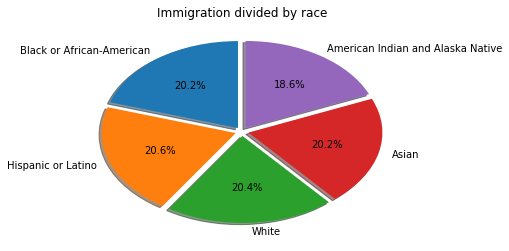

In [165]:
# We use graphing functions to show what percentage of each breed there is in the United States
plt.pie(data_race, labels=name, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Immigration divided by race')
plt.show()

In [166]:
age = [(demo_df[(demo_df['median_age']>20) & (demo_df['median_age']<=25)]).count(),
       (demo_df[(demo_df['median_age']>25) & (demo_df['median_age']<=30)]).count(),
       (demo_df[(demo_df['median_age']>30) & (demo_df['median_age']<=35)]).count(),
       (demo_df[(demo_df['median_age']>35) & (demo_df['median_age']<=40)]).count(),
       (demo_df[(demo_df['median_age']>40) & (demo_df['median_age']<=45)]).count(),
       (demo_df[(demo_df['median_age']>45) & (demo_df['median_age']<=50)]).count(),
       (demo_df[(demo_df['median_age']>50) & (demo_df['median_age']<=55)]).count(),
       (demo_df[(demo_df['median_age']>55) & (demo_df['median_age']<=60)]).count(),
       (demo_df[(demo_df['median_age']>60) & (demo_df['median_age']<=65)]).count(),
       (demo_df[(demo_df['median_age']>65) & (demo_df['median_age']<=70)]).count(),
       (demo_df[(demo_df['median_age']>70) & (demo_df['median_age']<=75)]).count()] 
print(age)

[34, 343, 1287, 925, 262, 37, 0, 0, 0, 3, 0]


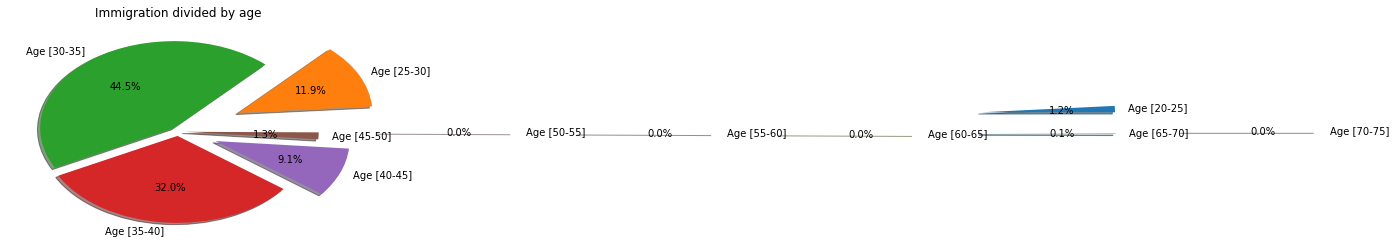

In [167]:
# We use the graphing functions to show what percentage of each age type divided between 20 and 75 years
range_age = ['Age [20-25]','Age [25-30]','Age [30-35]', 'Age [35-40]', 'Age [40-45]', 'Age [45-50]',
    'Age [50-55]', 'Age [55-60]', 'Age [60-65]', 'Age [65-70]', 'Age [70-75]']
explode = [6, 0.5, 0.05, 0.05, 0.3, 0.05, 1.5, 3, 4.5, 6, 7.5]  # Destacar algunos
plt.pie(age, labels=range_age, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=0)
plt.title('Immigration divided by age')
plt.show()

Finally, the demographic table, "demo_df" have the next column which will be explained below:

 - city (string): city name
 
 - state (string): state name
 
 - median_age (float): average age
 
 - male_population (float): number of males
 
 - female_population (float): number of women
 
 - total_population (float): total population
 
 - num_veterans (float): number of veterans
 
 - Foreign_born (float): number of foreigners
 
 - average_hhs (float): average number of people living in a house
 
 - state_code (string): state code
 
 - race (string): race
 
 - count (float): count of immigrant entries to the US.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

The dimension tables that will be immigrant_dimension, demographic_dimension, temperature_dimension and immigration_fact are listed below.

The columns will be the following:
## immigration_fact
 - id_immigration
 - type
 - visatype
 - port_city
## immigrant_dimension
- id_immigration
- origin
- destination
- code_city_destination
- arrival_date
- travel
- addr
- depdate
- birth
- biryear
- gender
- airline
- admission_number
## demographic_dimension
- city 
- state
- median_age
- male_population
- female_population
- total_population
- num_veterans
- foreign_born
- average_hhs
- state_code
- race
- count
## temperature_dimension
- date
- average_temperature
- average_temperature_uncertainty
- city
- country
- latitude
- longitude

In [168]:
#Create dimension table for immigrant
immigrant_dimension = i94_df.select("id_immigration", "origin", "destination", "code_city_destination", "arrival_date", \
                                      "travel", "addr", "depdate", "birth", "biryear", "gender", "airline", "admission_number")

In [169]:
immigrant_dimension.count()

2709889

In [170]:
immigrant_dimension.limit(5).toPandas()

,id_immigration,origin,destination,code_city_destination,arrival_date,travel,addr,depdate,birth,biryear,gender,airline,admission_number
0,5908962.0,INVALID: UNKNOWN,POLAND,SDP,2016-04-11,Rot reported,None,None,53,1963.0,M,None,4.355831e+10
1,5419796.0,BULGARIA,BULGARIA,WPB,2016-04-18,Rot reported,FL,None,42,1974.0,M,None,1.356816e+10
2,5934196.0,ITALY,ITALY,CHM,2016-04-16,Rot reported,NY,None,45,1971.0,M,None,5.782834e+10
3,6051481.0,ITALY,ITALY,CHM,2016-04-04,Rot reported,NY,None,39,1977.0,M,None,5.782834e+10
4,5936943.0,ITALY,ITALY,LNB,2016-04-22,Rot reported,None,None,45,1971.0,M,None,9.274616e+10


In [171]:
#Create dimension table for demographics
demographic_dimension = demo_df

In [172]:
demographic_dimension.limit(5).toPandas()

,city,state,median_age,male_population,female_population,total_population,num_veterans,foreign_born,average_hhs,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463.0,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924.0
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629.0,4147.0,32935.0,2.39,MA,White,58723.0
2,Hoover,Alabama,38.5,38040.0,46799.0,84839.0,4819.0,8229.0,2.58,AL,Asian,4759.0
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232.0,5821.0,33878.0,3.18,CA,Black or African-American,24437.0
4,Newark,New Jersey,34.6,138040.0,143873.0,281913.0,5829.0,86253.0,2.73,NJ,White,76402.0


In [173]:
#Create dimension table for temperature
temperature_dimension = temperature_df

In [174]:
temperature_dimension.limit(5).toPandas()

,date,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
0,1932-01-01,5.79,0.51,Abilene,United States,32.95N,100.53W
1,1942-07-01,27.31,0.26,Abilene,United States,32.95N,100.53W
2,1967-01-01,7.05,0.28,Abilene,United States,32.95N,100.53W
3,1987-09-01,22.76,0.34,Abilene,United States,32.95N,100.53W
4,1990-03-01,12.22,0.1,Abilene,United States,32.95N,100.53W


In [175]:
# Create fact table for immigration
immigration_fact = i94_df.select("id_immigration", "type", "visatype", "port_city").drop_duplicates()

In [176]:
immigration_fact.limit(5).toPandas()

,id_immigration,type,visatype,port_city
0,6050399.0,Business,B1,DALLAS
1,5513810.0,Business,B1,CHICAGO
2,1975186.0,Business,B1,ST PAUL
3,1777631.0,Business,B1,ST PAUL
4,5014193.0,Business,B1,DETROIT


In [177]:
# Write dimension tables to parquet
immigrant_dimension.write.mode("overwrite").partitionBy("gender", "addr").parquet("immigrants")
demographic_dimension.write.mode("overwrite").partitionBy("state").parquet("demographic")
temperature_dimension.write.mode("overwrite").parquet("temperature")

# Write fact table to parquet
immigration_fact.write.mode("overwrite").partitionBy("port_city").parquet("immigration")

In [178]:
def table_exists(df):
    if df is not None:
        return True
    else:
        return False

def table_not_empty(df):
    return df.count() != 0 

In [179]:
if table_exists(immigrant_dimension) & table_exists(demographic_dimension) & table_exists(temperature_dimension) & table_exists(immigration_fact):
    print("data quality check passed")
    print("dimension tables and fact table exist")
    print()
else:
    print("data quality check failed")
    print("table missing...")

data quality check passed
dimension tables and fact table exist



In [180]:
if table_exists(immigrant_dimension) & table_exists(demographic_dimension) & table_exists(temperature_dimension) & table_exists(immigration_fact):
    print("data quality check passed!")
    print("dimension tables and fact table contain records")
    print()
else:
    print("data quality check failed!")
    print("null records...")

data quality check passed!
dimension tables and fact table contain records



#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

    This project was made with Spark because it is able to process a large amount of data and it can do so fast and so easy. Spark can also work with different kinds of formats and it was something necessary in this project due here it was used format as SAS, CSV, Parquet and theses kind of format can integrate very well with S3 and Redshift.

* Propose how often the data should be updated and why.

    The update of data will be each month because it is the reason more logical whether it is attended to the necessity of the table and, such the temperature data as immigration data and demographic data can be updated each month with new temperatures and new immigrants.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
     It can migrate to Elastic Map Reduce instance on Amazon Web Side and allow it to scale as needed. 
     
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
     If this situation comes, it can use Airflow where will be programed and automatized the data pipeline jobs, and also it must have a retry mechanic in case something fails, the system can repeat the process.
     
 * The database needed to be accessed by 100+ people.
 
     In this case, it can use Redshift to have the data stored and so many people can access the information easily.
     